# Ligand-Receptor Inference

As a result of the growing interest in cell-cell communication (CCC) inference, a number of computational tools in single-cell transcriptomics have emerged. Although, there many different categories and approaches to infer CCC events, in this tutorial we will focus on those that infer interactions between ligands and receptors, commonly referred to as ligand-receptor (LR) inference methods (e.g. ([Efremova et al., 2020](https://www.nature.com/articles/s41596-020-0292-x), [Hou et al., 2020](https://www.nature.com/articles/s41467-020-18873-z), [Jin et al., 2021](https://www.nature.com/articles/s41467-021-21246-9), [Raredon et al., 2022](https://www.nature.com/articles/s41598-022-07959-x)). These tools typically rely on gene expression information as a proxy of protein abundance, and they work downstream of data pre-processing and acquisition of biologically-meaningful cell groups. These CCC tools infer intercellular interactions in a hypothesis-free manner, meaning that they infer all possible interactions between cell clusters, relying on prior knowledge of the potential interactions. Here, one group of cells is considered the source of the communication signal, sending a ligand, and the other is the receiver of the signal via its receptors. CCC events are thus represented as interactions between LR pairs, expressed by any combination of source and receiver cell groups.

The information about the interacting proteins is commonly extracted from prior knowledge resources. In the case of LR methods, the interactions can also be represented by heteromeric protein complexes ([Efremova et al., 2020](https://www.nature.com/articles/s41596-020-0292-x), [Jin et al., 2021](https://www.nature.com/articles/s41467-021-21246-9), [Noël et al., 2021](https://www.nature.com/articles/s41467-021-21244-x)). 

Here, we will use LIANA to obtain a consensus score for each LR interaction inferred by the different tools. Further, we will make use of LIANA's consensus resource, which combines a number of expert-curated LR resources.

## Environment Setup

In [ ]:
library(liana, quietly = TRUE)

library(scater, quietly = TRUE)

library(dplyr, quietly = TRUE)
library(reshape2, quietly = TRUE)
library(tidyr, quietly = TRUE)

library(ggplot2, quietly = TRUE)

## Directories

In [2]:
data.path <- file.path('..', '..', 'data')
output_folder <- file.path(data.path, 'liana-outputs/')

## Data Reminder

Here, we will re-load the processed data as processed in Tutorial 01.

**Change this to reading directly from Seurat once tutorial 01 in R is fully completed**

In [3]:
covid_data <- readRDS(file.path(data.path, 'covid_balf_norm.rds'))

just as a quick reminder, let's visualize the cell types and samples in the data.

In [4]:
head(covid_data@colData)

DataFrame with 6 rows and 13 columns
                      orig.ident      sample  sample_new     disease
                     <character> <character> <character> <character>
AAACCCACAGCTACAT-1_1        C100        C100         HC3           N
AAACCCATCCACGGGT-1_1        C100        C100         HC3           N
AAACCCATCCCATTCG-1_1        C100        C100         HC3           N
AAACGAACAAACAGGC-1_1        C100        C100         HC3           N
AAACGAAGTCGCACAC-1_1        C100        C100         HC3           N
AAACGAAGTCTATGAC-1_1        C100        C100         HC3           N
                         hasnCoV   cluster   cell.type   condition    ident
                     <character> <integer> <character> <character> <factor>
AAACCCACAGCTACAT-1_1           N        27           B     Control     C100
AAACCCATCCACGGGT-1_1           N        23 Macrophages     Control     C100
AAACCCATCCCATTCG-1_1           N         6           T     Control     C100
AAACGAACAAACAGGC-1_1           

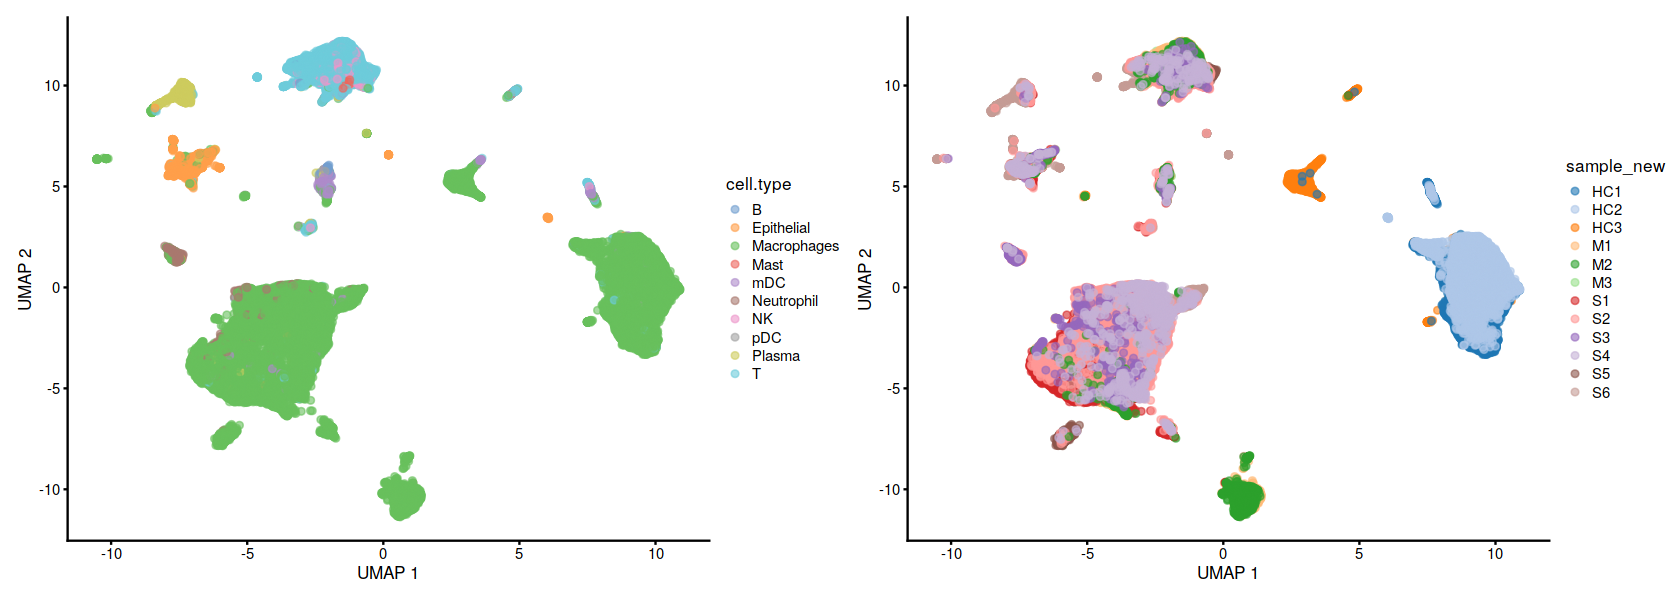

In [5]:
h_ = 5
w_ = 14
options(repr.plot.height=h_, repr.plot.width=w_)

n.pcs <- 20
# scran::buildSNNGraph(covid_data, use.dimred = 'PCA', d = n.pcs, )
g1 <- scater::plotUMAP(covid_data, colour_by = 'cell.type')
g2 <- scater::plotUMAP(covid_data, colour_by = 'sample_new')

patchwork::wrap_plots(g1, g2, ncol = 2)

## Predicting CCC events with LIANA


<img src="https://github.com/saezlab/liana/blob/master/vignettes/ligrec_pipe.png?raw=true" width="900"/>


Now that we have the preprocessed data loaded, we will use liana to score the interactions inferred by the different tools.

`liana` is highly modularized and it implements a number of methods to score LR interactions, we can list those with the following command: 

In [6]:
liana::show_methods()

[1] "connectome"      "logfc"           "natmi"           "sca"            
 [5] "cellphonedb"     "cytotalk"        "call_squidpy"    "call_cellchat"  
 [9] "call_connectome" "call_sca"        "call_italk"      "call_natmi"

LIANA classifies interaction scores into two categories: those that infer the **Magnitude** and **Specificity** of interactions. The **Magnitude** of an interactions is a measure of the strength of the interaction's expression, and the **Specificity** of an interaction is a measure of how specific is an interaction to a given pair of clusters. Generally, these categories are complementary, and the magnitude of the interaction is a proxy of the specificity of the interaction. For example, a ligand-receptor interaction with a high magnitude score is likely to be specific, and vice versa. 

## Scoring Functions

We will now describe the mathematical formulation of the magnitude and specificity scores we will use in this tutorial:

### Shared Notations


`k` is the k-th ligand-receptor interaction 

`L` - expression of ligand L

`R` - expression of receptor R

`C` - cell cluster

`i` - cell group i

`j` - cell group j

`M` - the library-size normalized and log1p-transformed gene expression matrix

`X` - normalized gene expression vector


### CellPhoneDBv2
**Magnitude**: $$ LRmean_{k,i,j} = \frac{L_{C_{i}} + R_{C_{j}}}{2}$$

**Specificity**: CellPhoneDBv2 introduced a **permutation approach** also adapted by other methods, see permutation formulation below.


**Specificity**: CellPhoneDBv2 introduced a **permutation approach** also adapted by other methods, see permutation formulation below.



### Geometric Mean
**Magnitude**: $$ LRgeometric.mean_{k,i,j} = \sqrt{L_{C_{i}} \cdot R_{C_{j}}}$$

**Specificity**:
An adaptation of CellPhoneDBv2's permutation approach.


### CellChat (a resource-agnostic adaptation)

**Magnitude**:

$$ LRprob_{k,i,j} = \frac{TriMean(L_{C_{i}}) \cdot

TriMean(R_{C_{j}})}{Kh + TriMean(L_{C_{i}}) \cdot

TriMean(R_{C_{j}})} $$

where Kh = 0.5 by default and `TriMean` represents Tuckey's Trimean function:

$$TriMean(X) = \frac{Q_{0.25}(X) + 2 \cdot Q_{0.5}(X) + Q_{0.75}(X)}{4}$$

Note that the original CellChat implementation also uses information of mediator proteins, which is specific to the CellChat resource.
Since we can use any resource with liana, by default liana's consensus resource, we will not use this information, and hence the implementation of CellChat's `LR_probability` in LIANA was simplified to be resource-agnostic.

**Specificity**:
An adaptation of CellPhoneDBv2's permutation approach.



##### The specificity scores of these three method is calculated as follows:

$$p\text{-value}_{k,i,j} = \frac{1}{P} \sum_{p=1}^{P} [fun_{permuted}(L^*_{C_{i}}, R^*_{C_{j}}) \geq fun_{observed}(L^*_{C_{i}}, R^*_{C_{j}})]$$

where `P` is the number of permutations, and `L*` and `R*` are ligand and receptor expression summarized according by each method, i.e. `arithmetic mean` for CellPhoneDB and Geometric Mean, and `TriMean` for CellChat.


### SingleCellSignalR

**Magnitude**:

$$LRscore_{k,i,j} = \frac{\sqrt{L_{C_{i}} R_{C_{j}}}}{\sqrt{L_{C_{i}} R_{C_{j}}} + \mu}$$

where `mu` is the mean of the expression matrix `M`


### NATMI

**Magnitude**: $$LRproduct_{k,i,j} = L_{C_{i}} R_{C_{j}}$$

**Specificity**: $$SpecificityWeight_{k,i,j} = \frac{L_{C_{i}}}{\sum^{n} L_{C_{i}}} \cdot \frac{R_{C_{j}}}{\sum^{n} R_{C_{j}}}$$


### Connectome

**Magnitude**: $$LRproduct_{k,i,j} = L_{C_{i}} R_{C_{j}}$$

**Specificity**:  $$ LRz.mean_{k,i,j} = \frac{z_{L_{C_{i}}} + z_{R_{C_{j}}}}{2} $$

where `z` is the z-score of the expression matrix `M`:

$$ X_{z} = (X - mean(X)) / std(X) $$


### log2FC

**Specificity**: $$ LRlog2FC_{k,i,j} = \frac{\text{Log2FC}_{C_i,L} + \text{Log2FC}_{C_j,R}}{2} $$


where log2FC for each gene is calculated as: $$ log2FC = \log_2\left(\text{mean}(X_i)\right) - \log_2\left(\text{mean}(X_{\text{not}_i})\right) $$



What the above equations show is that there are many commonalities between the different methods, yet there are also many variations in the way the magnitude and specificity scores are calculated. 

$$ I \left\{ L_{C_j}^{expr.prop} \geq 0.1 \text{ and } R_{C_j}^{expr.prop} \geq 0.1 \right\} $$

where liana considers interactions as occurring only if the ligand and receptor, and **all** of their subunits, are expressed by default in at least 0.1 of the cells (`>= expr_prop`) in cell clusters `i`, `j`.
Any interactions that don't pass these criteria are not returned by default, to return them the user can check the `return_all_lrs` parameter.

### Score Distributions

In [7]:
# pick a sample to infer the communication scores for
md <- covid_data@colData
barcodes <- rownames(md[md$sample == 'C100', ])

sdata <- covid_data[, barcodes]
sdata

class: SingleCellExperiment 
dim: 24798 2550 
metadata(0):
assays(2): counts logcounts
rownames(24798): AL627309.1 AL627309.3 ... AC233755.1 AC240274.1
rowData names(0):
colnames(2550): AAACCCACAGCTACAT-1_1 AAACCCATCCACGGGT-1_1 ...
  TTTGTTGCAATGAAAC-1_1 TTTGTTGCAGAGGGTT-1_1
colData names(13): orig.ident sample ... total subsets_Mito_percent
reducedDimNames(2): PCA UMAP
mainExpName: RNA
altExpNames(0):

The parameters that we will use are the following:
- `idents_col` is the column in the `meta` dataframe that contains the cell groups
- `assay` is a string that indicates which Seurat assay to use (typically `RNA`, unless having done a batch correction step)
- `assay.type` is a string that indicates whether to use the raw (`counts`) or log- and library-normalized (`logcounts`) counts attribute of the Seurat object assay. Since most CCC tools expect library- and log-normalized data, we will use that. 
- `expr_prop` is the expression proportion threshold  (in terms of cells per cell type expressing the protein)threshold of expression for any protein subunit involved in the interaction, according to which we keep or discard the interactions.
- `min_cells` is the minimum number of cells per cell type required for a cell type to be considered in the analysis
- `verbose` is a boolean that indicates whether to print the progress of the function

(Other parameters are described in the documentation of the function, as well as in more detail below)

In [8]:
liana_res <- liana_wrap(sce = sdata, 
                        idents_col = 'cell.type', 
                        assay.type = 'logcounts',                     
                        min_cells=5,  
                        expr_prop=0.1, 
                        permutation.params=list(nperms=100),
                        verbose=TRUE
                        # , parallelize = TRUE , workers = 8
                      )

Running LIANA with `cell.type` as labels!

`Idents` were converted to factor

Cell identities with less than 5 cells: Plasma were removed!

Warning message in exec(output, ...):
“5591 genes and/or 0 cells were removed as they had no counts!”
Warning message:
“`invoke()` is deprecated as of rlang 0.4.0.
Please use `exec()` or `inject()` instead.
This warning is displayed once per session.”
LIANA: LR summary stats calculated!

Now Running: Natmi

Now Running: Connectome

Now Running: Logfc

Now Running: Sca

Now Running: Cellphonedb



liana returns a list of results, each element of which corresponds to a method

In [9]:
liana_res %>% dplyr::glimpse()

List of 5
 $ natmi      : tibble [9,911 × 14] (S3: tbl_df/tbl/data.frame)
  ..$ source          : chr [1:9911] "B" "B" "B" "B" ...
  ..$ target          : chr [1:9911] "B" "B" "B" "B" ...
  ..$ ligand.complex  : chr [1:9911] "HLA-B" "HLA-A" "FCER2" "FCER2" ...
  ..$ ligand          : chr [1:9911] "HLA-B" "HLA-A" "FCER2" "FCER2" ...
  ..$ receptor.complex: chr [1:9911] "LILRB1" "LILRB1" "ITGAX_ITGB2" "CR2" ...
  ..$ receptor        : chr [1:9911] "LILRB1" "LILRB1" "ITGAX" "CR2" ...
  ..$ receptor.prop   : num [1:9911] 0.111 0.111 0.111 0.111 0.111 ...
  ..$ ligand.prop     : num [1:9911] 0.889 0.778 0.222 0.222 0.222 ...
  ..$ ligand.expr     : num [1:9911] 2.522 2.043 0.377 0.377 0.34 ...
  ..$ receptor.expr   : num [1:9911] 0.237 0.237 0.345 0.173 0.173 ...
  ..$ ligand.sum      : num [1:9911] 19.296 19.192 0.381 0.381 2.687 ...
  ..$ receptor.sum    : num [1:9911] 1.321 1.321 4.268 0.173 0.463 ...
  ..$ prod_weight     : num [1:9911] 0.5985 0.4848 0.1304 0.0652 0.0588 ...
  ..$ edge_

### LIANA's Rank Aggregate

LIANA can calculate an aggregate rank for both `magnitude` and `specificity` as defined above. The `rank_aggregate` function of liana uses a re-implementation of the RobustRankAggregate method by [Kolde et al., 2012](https://pubmed.ncbi.nlm.nih.gov/22247279/), and generates a probability distribution for ligand-receptors that are ranked consistently better than expected under a null hypothesis. It thus provides a consensus of the rank of the ligand-receptor interactions across methods, that can also be treated as a p-value.

In more detail, a rank aggregate is calculated for the `magnitude` and `specificity` scores from the methods in LIANA as follows:

First, a normalized rank matrix[0,1] is generated separately for magnitude and specificity as: $$ r_{i,j} = \frac{rank_{i,j}}{\max(rank_i)} \quad (1 \leq i \leq m, 1 \leq j \leq n) $$


where `m` is the number of score rank vectors, `n` is the length of each score vector (number of interactions), **rank<sub>i,j</sub>** is the rank of the `j-th` element (interaction) in the `i-th` score rank vector, and **max(rank<sub>i</sub>)** is the maximum rank in the `i-th` rank vector.

For each normalized rank vector `r`, we then ask how probable is it to obtain **r<sup>null</sup><sub>(k)</sub> <= r<sub>(k)</sub>**, where **r<sup>null</sup><sub>(k)</sub>** is a rank vector generated under the null hypothesis. The RobustRankAggregate method expresses [Kolde et al., 2012](https://pubmed.ncbi.nlm.nih.gov/22247279/) the probability **r<sup>null</sup><sub>(k)</sub> <= r<sub>(k)</sub>** as **β<sub>k,n</sub>(r)**, through a beta distribution. 
This entails that we obtain probabilities for each score vector `r` as: $$ p(r) = \underset{1, ..., n}{min} \beta_k,_n(r) * n $$



where we take the minimum probability `ρ` for each interaction across the score vectors, and we apply a Bonferroni correction to the p-values by multiplying them by `n` to account for multiple testing.

Aggregate scores are also non-negative, which is beneficial for decomposition with Tensor-cell2cell.

Calculate both the magnitude and specificity consensus rank scores:

In [10]:
liana_agg <- rank_aggregate(liana_res = liana_res)

Now aggregating natmi

Warning message in exec(output, ...):
“Unknown method name or missing specifics for: connectome”
Warning message in exec(output, ...):
“Unknown method name or missing specifics for: logfc”
Now aggregating sca

Now aggregating cellphonedb

Aggregating Ranks

Now aggregating natmi

Now aggregating connectome

Now aggregating logfc

Warning message in exec(output, ...):
“Unknown method name or missing specifics for: sca”
Now aggregating cellphonedb

Aggregating Ranks



Here, for each scoring type of specificity and magnitude, we can see the different scores for each method as well as the consensus scores. Consensus scores are delineated by the `specificity_rank` and `magnitude_rank` columns.

In [11]:
head(liana_agg)

source,target,ligand.complex,receptor.complex,magnitude_rank,specificity_rank,magnitude_mean_rank,natmi.prod_weight,sca.LRscore,cellphonedb.lr.mean,specificity_mean_rank,natmi.edge_specificity,connectome.weight_sc,logfc.logfc_comb,cellphonedb.pvalue
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
T,NK,B2M,KLRC1,3.081547e-12,0.0009488783,1,11.67941,0.9585912,3.751150,733.00,0.09416852,1.770161,1.252456,0
NK,NK,B2M,KLRC1,2.465238e-11,0.0013326386,2,11.62518,0.9584987,3.738849,745.00,0.09373123,1.746263,1.170207,0
T,NK,B2M,KLRD1,8.320177e-11,0.0005938262,3,11.36870,0.9580527,3.721824,651.50,0.10434592,2.078208,1.311870,0
T,T,B2M,CD3D,1.972190e-10,0.0062312181,4,11.33366,0.9579907,3.718518,967.25,0.06945486,1.280943,1.291357,0
NK,NK,B2M,KLRD1,3.851934e-10,0.0013406185,5,11.31590,0.9579591,3.709524,665.00,0.10386136,2.054311,1.229621,0
NK,T,B2M,CD3D,6.656142e-10,0.0063459294,6,11.28103,0.9578969,3.706217,983.00,0.06913233,1.257045,1.209108,0


In [12]:
# Pivot to a long format
scores_long <- liana_agg %>%
    pivot_longer(cols = -c('source', 'target', 'ligand.complex', 'receptor.complex'),
    names_to = 'score', values_to = 'value')

In [13]:
head(scores_long)

source,target,ligand.complex,receptor.complex,score,value
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
T,NK,B2M,KLRC1,magnitude_rank,3.081547e-12
T,NK,B2M,KLRC1,specificity_rank,9.488783e-04
T,NK,B2M,KLRC1,magnitude_mean_rank,1.000000e+00
T,NK,B2M,KLRC1,natmi.prod_weight,1.167941e+01
T,NK,B2M,KLRC1,sca.LRscore,9.585912e-01
T,NK,B2M,KLRC1,cellphonedb.lr.mean,3.751150e+00


For clarity, here we map each output score (column names in the above dataframe) to the scoring method and scoring type:

| Method Name | Magnitude Score | Specificity Score |
| :- | -: | :-: |
| CellPhoneDB | lr.mean | cellphonedb.pvalue
| Connectome | prod_weight | weight_sc
| log2FC | None | logfc_comb
| NATMI | prod_weight | edge_specificity
| SingleCellSignalR (sca) | LRscore | None

### Score Distributions

To provide a better illustration of the different scores, we will now plot the distribution of scores for each of the methods.

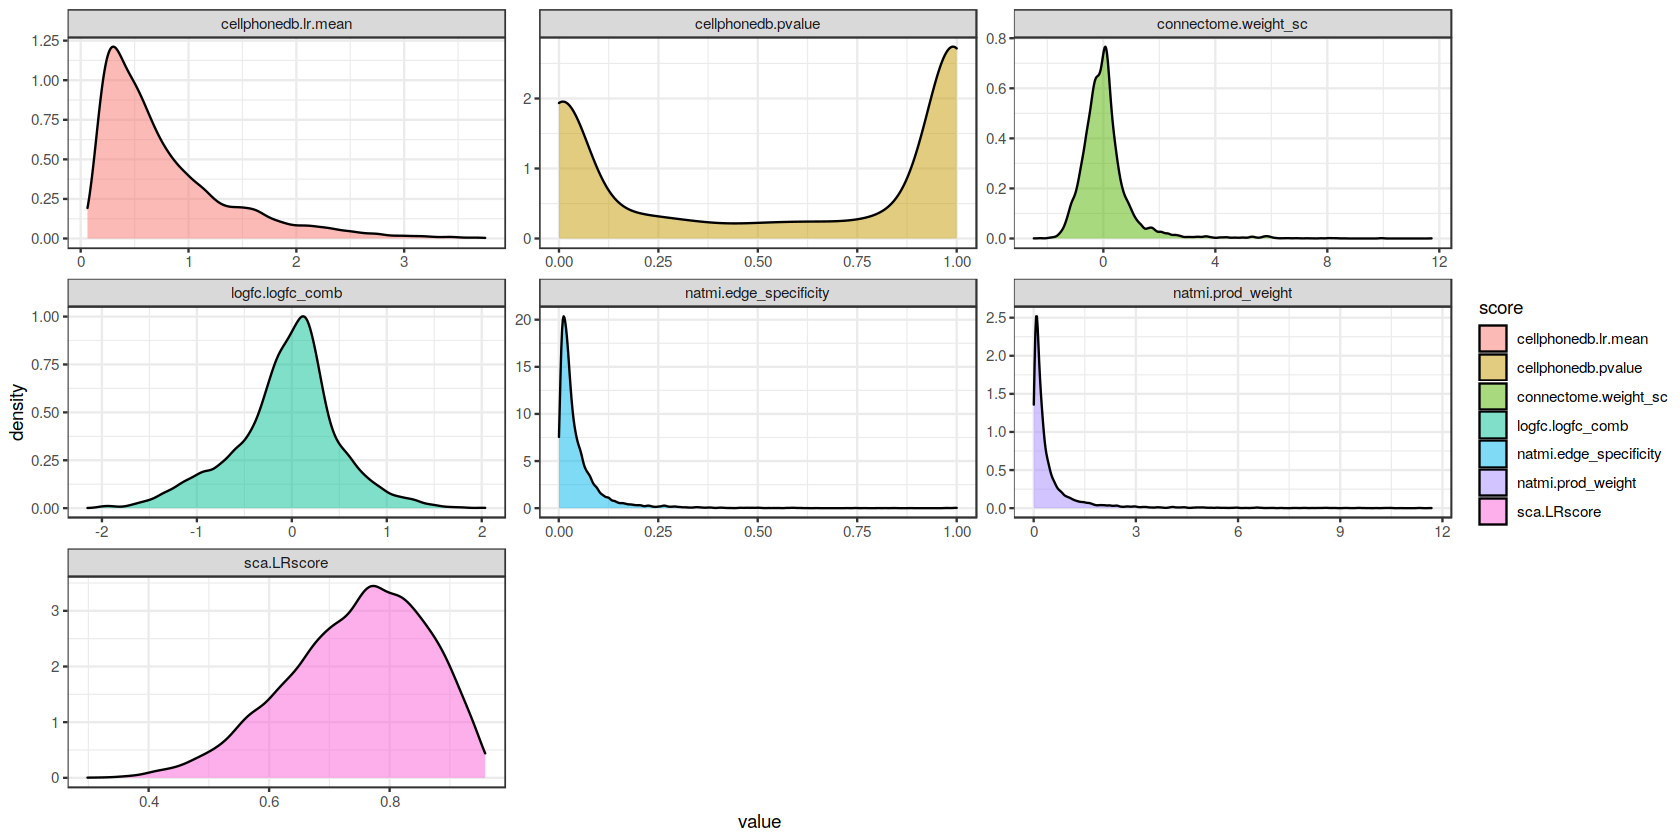

In [14]:
h_ = 7
w_ = 14
options(repr.plot.height=h_, repr.plot.width=w_)

# keep only method scores
scores_long <- scores_long %>% filter(!stringr::str_detect(score, "rank"))

ggplot(scores_long, aes(x = value, fill = score)) +
    geom_density(alpha = 0.5) + 
    facet_wrap('~score', scales='free', ncol = 3) +
    theme_bw()

This show the extent to which  each of the scoring functions differ from each other. Unsurprisingly, independent evaluations have shown that the choice of method and/or resource leads to limited consensus in inferred predictions when using different tools ([Dimitrov et al., 2022](https://www.nature.com/articles/s41467-022-30755-0), [Liu et al., 2022](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-022-02783-y), [Wang et al., 2022](https://academic.oup.com/bfg/article/21/5/339/6640320)). This is why we have implemented a consensus score that is a rank aggregate of the scores obtained by the different methods, and for the sake of these tutorials we will use this consensus score to rank the interactions, specifically the one that aggregates the magnitude scores from different functions. Aggregate scores are also non-negative, which is beneficial for decomposition with Tensor-cell2cell.

### Single-Sample Dotplot

Let's generate a basic dotplot with the most highly-ranked ligand-receptor interactions for this sample from LIANA's aggregate scores. 

In [18]:
liana_agg_int <- liana_agg %>%
  # only keep interactions with p-val <= 0.05
  filter(specificity_rank <= 0.05) %>% 
  distinct_at(c("ligand.complex", "receptor.complex")) 

In [19]:
# keep only those interactions that are significant in at least one cell pair, and rank to magnitude
liana_agg <- liana_agg %>%
  # keep only the interactions of interest
  inner_join(liana_agg_int, 
             by = c("ligand.complex", "receptor.complex")) %>%
  # then rank according to `magnitude`
  arrange(magnitude_rank)

Since both lower specificity and lower magnitude consensus rank scores have higher communication importance, we set the invert parameters to TRUE:

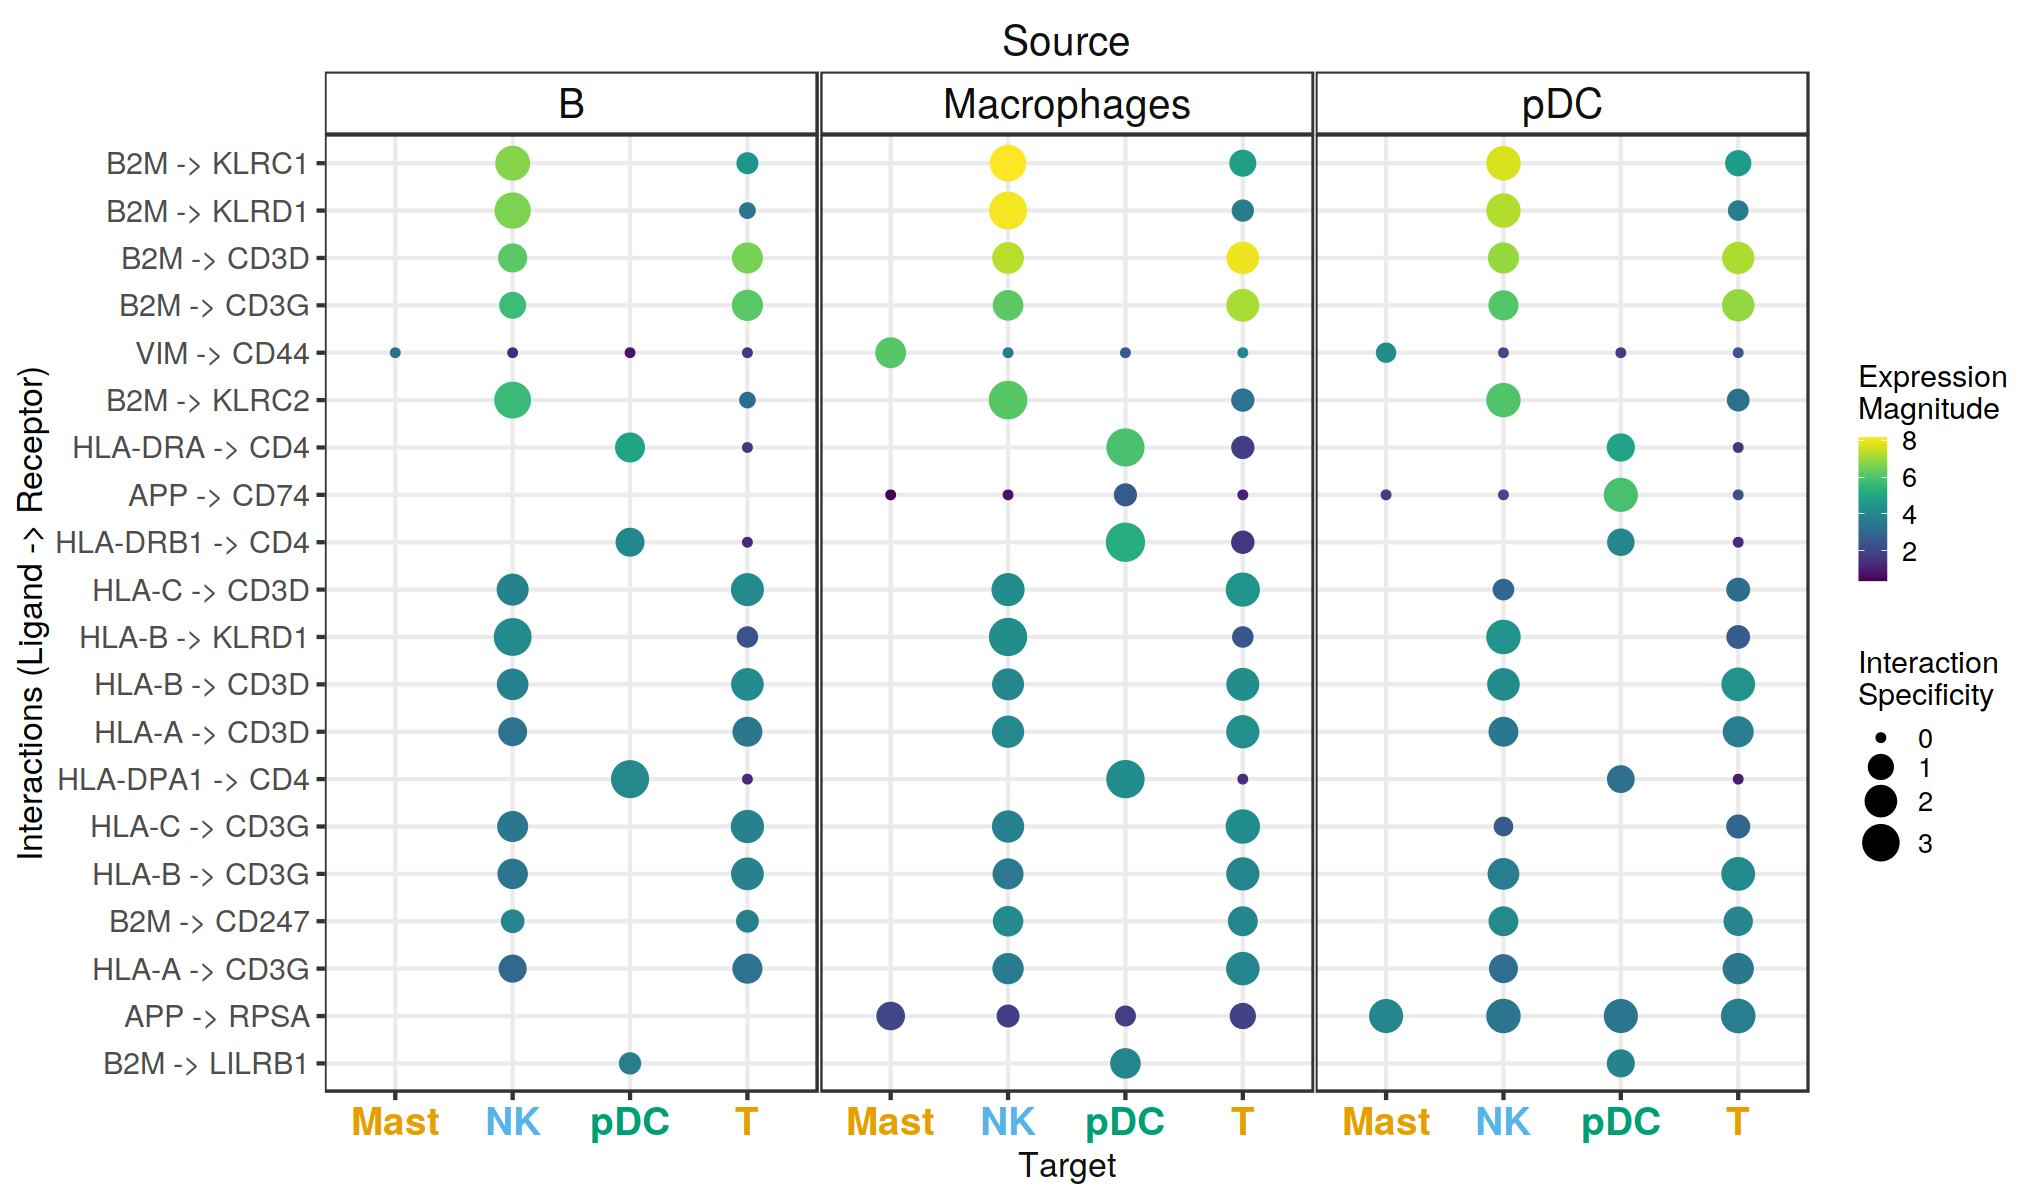

In [20]:
h_ = 10
w_ = 17
options(repr.plot.height=h_, repr.plot.width=w_)

liana_dotplot(
  liana_agg,
  source_groups = c('B', 'Macrophages', 'pDC'),
  target_groups = c('Mast', 'NK', 'T', 'pDC'),
  ntop = 20,
  specificity = "specificity_rank",
  magnitude = "magnitude_rank",
  invert_magnitude = TRUE, 
  invert_specificity = TRUE
)

Great! We have now obtained ligand-receptor predictions for a single sample. What we see here is that interactions are predicted across cell types and are typically specific to pairs of cell types.

Note that missing dots here would represent interactions for which the ligand and receptor are expressed below the `expr_prop` threshold.

## Run LIANA by Sample

Now that we have familiarized ourselves with how ligand-receptor methods in LIANA work and how the results look by sample, let's run LIANA on all of the samples in the dataset. These results will be used to generate a tensor of ligand-receptor interactions across contexts that will be decomposed into CCC patterns by `Tensor-Cell2cell`.

This is easily done with liana with the `liana_bysample` function. This function takes the same inputs was `liana_wrap`, but it will also iterate across samples as specified in the metadata. It also automatically aggregates the scores by specifying `aggregate_how`.

We relax the `expr_prop` parameter to have more consistent presence of LR interactions across contexts. See further discussions on the `how` parameter in Tutorial 03. 

Results are stored in the SCE object as `sce@metadata$liana_res`

In [7]:
covid_data <- liana_bysample(sce = covid_data,
                             sample_col = "sample_new", # context dimension column from SCE metadata
                             idents_col = "cell.type", # cell types column from SCE metadata
                             expr_prop = 0.1, 
                             assay.type = 'logcounts',
                             aggregate_how = 'both',
                             verbose = TRUE,
                             permutation.params=list(nperms=100), 
                             # parallelize = TRUE
                             # workers = 8
                        )

`sample_new` was converted to a factor!

Current sample: HC1

Running LIANA with `cell.type` as labels!

`Idents` were converted to factor

Cell identities with less than 5 cells: pDC were removed!Cell identities with less than 5 cells: Plasma were removed!

Warning message in exec(output, ...):
“5711 genes and/or 0 cells were removed as they had no counts!”
LIANA: LR summary stats calculated!

Now Running: Natmi

Now Running: Connectome

Now Running: Logfc

Now Running: Sca

Now Running: Cellphonedb

Now aggregating natmi

Warning message in exec(output, ...):
“Unknown method name or missing specifics for: connectome”
Warning message in exec(output, ...):
“Unknown method name or missing specifics for: logfc”
Now aggregating sca

Now aggregating cellphonedb

Aggregating Ranks

Now aggregating natmi

Now aggregating connectome

Now aggregating logfc

Warning message in exec(output, ...):
“Unknown method name or missing specifics for: sca”
Now aggregating cellphonedb

Aggregating Ranks



### Check the results

Here, we can combine the results and see that they look very similar as before with the exception that we have an additional column for the sample name, and the results are now by sample.

In [50]:
liana_res <- covid_data@metadata$liana_res %>% 
            bind_rows(.id = "sample_new") %>%
            mutate(sample_new = factor(sample_new, levels = unique(sample_new)))

head(liana_res)

We can also generate a DotPlot for each sample.
Let's pick the first two distinct interaction in the list, and see what they look like.

In [51]:
ligand_complex <- 'B2M'
receptor_complex <- c('CD3D', 'KLRD1')
source_labels <- c("B", "pDC", "Macrophages")
target_labels <- c("T", "Mast", "pDC", "NK")
sample_key <- 'sample_new'
colour <- 'magnitude_rank'
size <- "specificity_rank"

Filter to interactions of interest, and invert the specificity and magnitude ranks to have higher scores indicate higher communication importance.

In [54]:
lv <- liana_res %>% 
    filter(source %in% source_labels) %>%
    filter(target %in% target_labels) %>%
    filter(ligand.complex %in% ligand_complex) %>%
    filter(receptor.complex %in% receptor_complex) %>%
    unite(lr.pairs, ligand.complex, receptor.complex, sep = ' -> ') %>%
    mutate(lr.pairs = factor(lr.pairs, levels = unique(lr.pairs))) %>%
    # inverse ranks
    mutate_at(vars(specificity_rank, magnitude_rank), ~-log10(. + 1e-10))

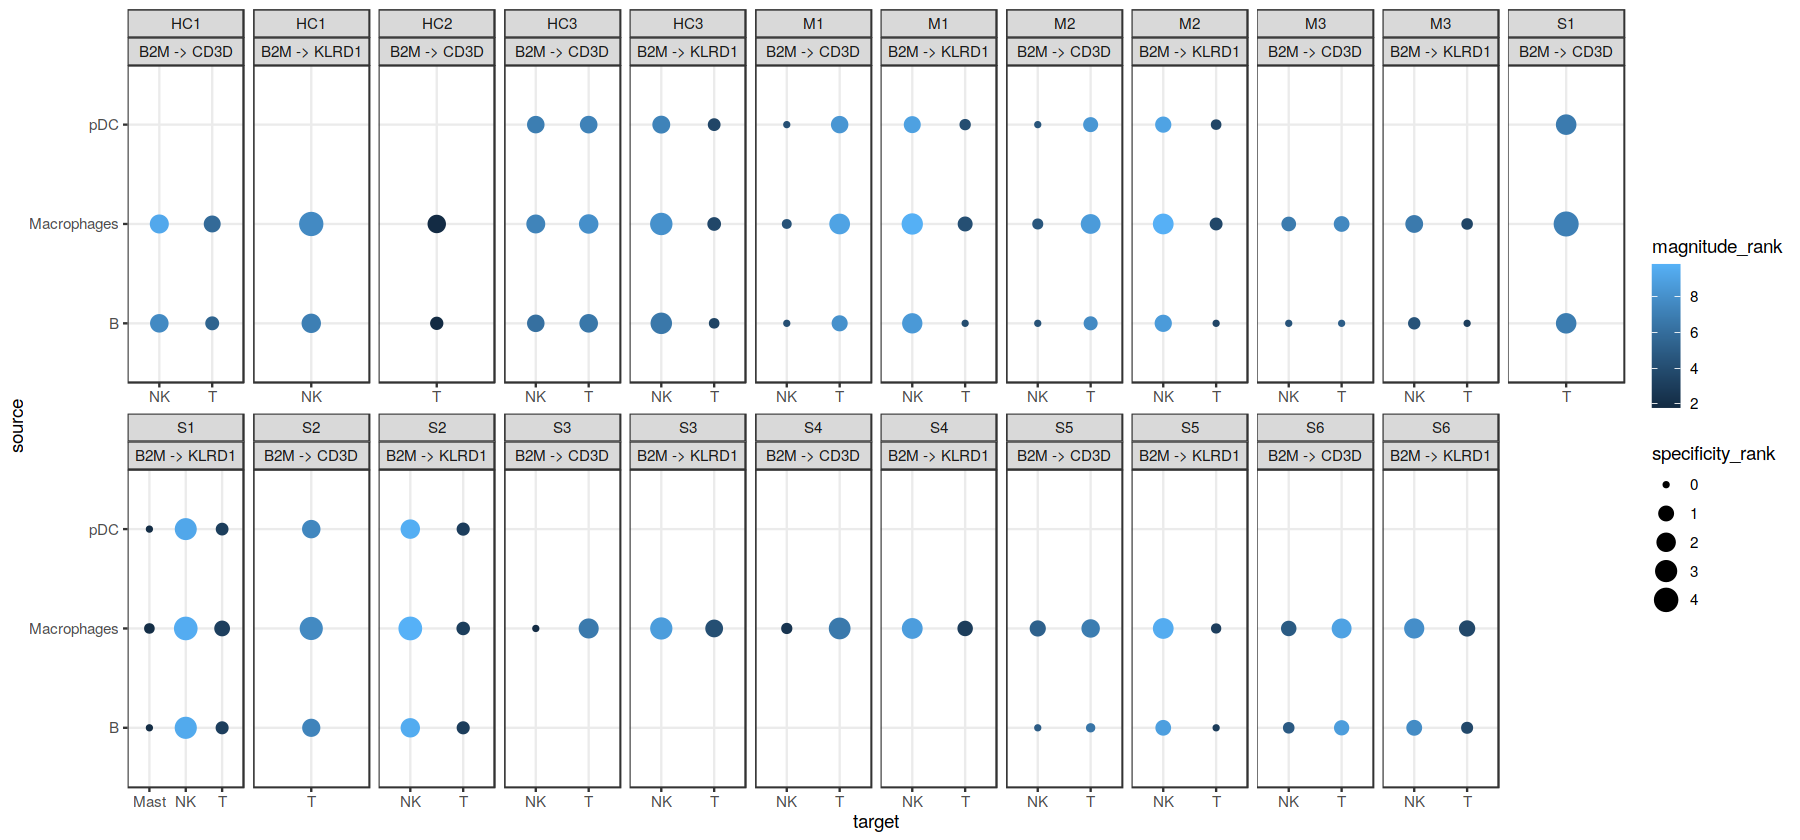

In [67]:
h_ = 7
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)

ggplot(lv, aes(x = target, y = source, color = .data[[colour]], size=.data[[size]])) +
        geom_point() + 
        facet_wrap(sample_new ~ lr.pairs, ncol = 12, scales='free_x') + 
        theme_bw()

Here, we can already see that the ligand-receptor interactions are not only specific to cell types, but also to samples or contexts (see **B2M -> KLRD1** in samples *M1*, *M2*, *M3*). However, we can also see that this plot, even with just two ligand-receptor interactions visualized, starts to get a bit overwhelming. To this end, to make the most use of the hypothesis-free nature of the ligand-receptor interactions, in the next chapter we will use `Tensor-Cell2cell` to decompose the ligand-receptor interactions into interpretable CCC patterns across contexts.

Save Results for Tensor-Cell2cell.

In [60]:
saveRDS(covid_data@metadata$liana_res, file.path(output_folder, 'LIANA_by_sample_R.rds'))

## Supplementary Information about LIANA

### Key Parameters

We already covered some of the parameters in LIANA, that can be used to customize the results. Here, we will go in more detail over some of the most important ones.


- `resource` and `resource_name` enable the user to select the resource that they want to use for CCC inference. By default, liana will use the 'consensus' resource which combines a number of expert-curated ligand-receptor resources. However, one can also use the 'cellphonedb' resource, any of the resources that are available within liana by passing their `resource_name` (See below). Additionally, the user can pass their own resource via the `resource` parameter, which expects a pandas DataFrame.


In [ ]:
show_resources()


- `expr_prop` which we also used before is the proportion of cells that need to express a ligand-receptor pair for it to be considered as a potential ligand-receptor pair. This is a parameter that can be used to filter out lowly-expressed ligand-receptor pairs. This is common practice in CCC inference at the cluster level, as we make the assumption that the event occurs for all cells within that clusters.

- `return_all_lrs` is related to the `expr_prop` parameter. If `return_all_lrs` is set to `True`, then all ligand-receptor pairs will be returned, regardless of whether they are expressed above the `expr_prop` threshold. This is useful if one wants to use the `expr_prop` parameter to filter out lowly-expressed ligand-receptor pairs, but still wants to see the scores for all ligand-receptor pairs.

In addition to those parameters liana provides a number of other utility parameters as well as some method-specific ones, please refer to the documentation for more information.

## Working with Seurat objects

In [9]:
library(Seurat, quietly = TRUE)

Load the Seurat object from the [Supplementary Tutorial](./SX_Preprocess_Expression_Seurat.ipynb)

In [ ]:
covid_data <- readRDS(file.path(data.path, 'covid_balf_norm_seurat.rds'))

To run on one sample is the same syntax as using a SCE object:

In [ ]:
# pick a sample to infer the communication scores for
sdata.so = subset(x = covid_data, subset = sample == 'C100')

Note, we can easily convert a Seurat object to a SingleCellExperiment object if preferred for easier compatibility with LIANA:

In [ ]:
sdata.sce <- Seurat::as.SingleCellExperiment(sdata.so)

Run LIANA on the Seurat object for one sample:

In [ ]:
liana_res <- liana_wrap(sce = sdata.so, 
                        idents_col='cell.type', 
                        assay='RNA', # specify the Seurat assay
                        assay.type = 'logcounts', 
                        expr_prop=0.1, 
                        verbose=T, 
                        parallelize = T, 
                        workers = 30)

Note, by default, LIANA runs all the available scoring methods. You can select only certain methods to run by specifiying the `method` argument. For example, if I only wanted to run CellPhoneDB and NATMI, I could specify it has follows:

In [ ]:
liana_res <- liana_wrap(sce = sdata.so, 
                        idents_col='cell.type', 
                        assay='RNA', # specify the Seurat assay
                        assay.type = 'logcounts', 
                        expr_prop=0.1,
                        method = c('cellphonedb', 'natmi') # only two scoring methods
                        verbose=T, 
                        parallelize = T, 
                        workers = 30)

Additionally, if you want to just rank by the magnitude or the specificity, rather than both, you can use the following. Here, since we filtered for only CellPhoneDB and NATMI in the cell above, this will only calculate a consensus score for those two methods. Since both these methods return a magnitude and specifity score, a consensus score can be calculated for each score type. 

In [ ]:
liana_aggregate.magnitude <- liana_aggregate(liana_res = liana_res, aggregate_how='magnitude', verbose = F)
liana_aggregate.specificity <- liana_aggregate(liana_res = liana_res, aggregate_how='specificity', verbose = F)

`liana_bysample` does not work directly on Seurat objects. However, we can manually iterate through samples to create a `context_df_dict` dictionary (named list) which can be used as input to the `liana_tensor_c2c` function used to build the tensor in Tutorial 03:

In [ ]:
context_df_dict<-list()
for (sample.name in sort(unique(covid_data$sample_new))){
    sdata_ = subset(x = covid_data, subset = sample_new == sample.name)
    liana_res_ <- liana_wrap(sce = sdata_, idents_col='cell.type', assay='RNA', assay.type = 'logcounts', 
                          expr_prop=0.05, verbose=F, parallelize = T, workers = 30)

    liana_aggregate.magnitude_ <- liana_aggregate(liana_res = liana_res_, aggregate_how='magnitude', verbose = F)
    
    # retain only the aggregate magnitude rank score
    # and format for input to liana_tensor_c2c function
    liana_aggregate.magnitude_<-liana_aggregate.magnitude_[1:5]
    colnames(liana_aggregate.magnitude_)<-c('source', 'target', 'ligand.complex', 'receptor.complex', 'magnitude_rank')
    liana_aggregate.magnitude_[['sample_new']]<-sample.name
    
    context_df_dict[[sample.name]]<-liana_aggregate.magnitude_
}

The output of this function can directly be input to the `liana_tensor_c2c` function used in Tutorial 03. For more details, see liana's tensor-cell2cell [tutorial](https://saezlab.github.io/liana/articles/liana_cc2tensor.html). 

### Rank Comparisons

**Probably want to remove this**
Let's see how the specificty and magnitude aggregate scores compare using a Spearman correlation:

In [ ]:
cor.test(lav$magnitude_rank, lav$specificity_rank, method = c('spearman'))$estimate[['rho']]

#### Comparison with Python output:

There are minor differences with the LIANA implementation in python that lead to outputs not being identical

- SingleCellSignalR Magnitude (LRscore): slightly different after 3rd decimal place
- LogFC Specificity (logfc_comb): similar relative differences but different exact values
- CellPhoneDB Specificity (pvalue): similar relative differences but different exact values
- CellChat: not run by default in R

To have more consistency with Python between, for example, the magnitude aggregate rank score, we can run LIANA using the two methods that are 100% consistent between the two languages (CellPhoneDB and NATMI) and re-calculate our magnitude score from just those two. 

In [ ]:
liana_res_partial <- liana_wrap(sce = sdata, idents_col='cell.type', assay='RNA', assay.type = 'logcounts', 
                      expr_prop=0.1, verbose=T, parallelize = T, workers = 30, 
                      method = c("natmi", "cellphonedb"))
liana_aggregate_partial <- liana_aggregate(liana_res = liana_res_partial, 
                                           aggregate_how='magnitude', verbose = F)
liana_aggregate_partial<-liana_aggregate_partial[c('source', 'target', 'ligand.complex', 'receptor.complex', 'aggregate_rank')]

head(liana_aggregate_partial)

Because the rank aggregation **insert explanation here**, the aggregated magnitude rank scores slightly differ in absolute value. However, they agree highly in terms of relative values, as seen by the Spearman correlation:

In [ ]:
liana_aggregate_partial <- plyr::arrange(liana_aggregate_partial, source, target, ligand.complex, receptor.complex)
write.csv(liana_aggregate_partial, paste0(output_folder, 'magnitude_ranks_R.csv'))

# read and format python aggregate rank
lap_python<-read.csv(paste0(output_folder, 'magnitude_ranks_python.csv'))
clp<-colnames(lap_python)
clp[4]<-'ligand.complex'
clp[5]<-'receptor.complex'
colnames(lap_python)<-clp
lap_python<-lap_python[colnames(lap_python) != 'X']

# merge the two scores
la<-dplyr::inner_join(liana_aggregate_partial, lap_python)

spearmanr<-cor.test(la$aggregate_rank, 
         la$magnitude_rank, method = c('spearman'))$estimate[['rho']]
print(paste0('The spearman correlation is: ', spearmanr))

In [ ]:
liana_aggregate.magnitude <- plyr::arrange(liana_aggregate.magnitude, source, target, ligand.complex, receptor.complex)
write.csv(liana_aggregate.magnitude, file.path(output_folder, 'magnitude_ranks_all_R.csv'))
